In [1]:
import sys
print(sys.path)

['/usr/local/spark/python', '/usr/local/spark/python/lib/py4j-0.10.6-src.zip', '/home/cms.bgalewsk/fnal-column-analysis-tools/p3/lib64/python36.zip', '/home/cms.bgalewsk/fnal-column-analysis-tools/p3/lib64/python3.6', '/home/cms.bgalewsk/fnal-column-analysis-tools/p3/lib64/python3.6/lib-dynload', '/usr/lib64/python3.6', '/usr/lib/python3.6', '', '/home/cms.bgalewsk/fnal-column-analysis-tools/p3/lib/python3.6/site-packages', '/home/cms.bgalewsk/fnal-column-analysis-tools/p3/lib/python3.6/site-packages/fnal_column_analysis_tools-0.2.3-py3.6.egg', '/home/cms.bgalewsk/fnal-column-analysis-tools/p3/lib/python3.6/site-packages/uproot-3.4.9-py3.6.egg', '/home/cms.bgalewsk/fnal-column-analysis-tools/p3/lib/python3.6/site-packages/uproot_methods-0.4.3-py3.6.egg', '/home/cms.bgalewsk/fnal-column-analysis-tools/p3/lib/python3.6/site-packages/scipy-1.2.1-py3.6-linux-x86_64.egg', '/home/cms.bgalewsk/fnal-column-analysis-tools/p3/lib/python3.6/site-packages/numpy-1.16.2-py3.6-linux-x86_64.egg', '/ho

In [2]:
import pyspark.sql
import os
import sys

from pyspark.sql import functions
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.accumulators import AccumulatorParam
from collections import OrderedDict

import awkward as awk
import numpy as np
import pandas as pd
import re
import fnal_column_analysis_tools.hist as hist

from pyspark.sql.types import IntegerType

from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray

os.environ['PYSPARK_PYTHON'] = sys.executable
session = pyspark.sql.SparkSession.builder \
    .appName("isrstau-00") \
    .getOrCreate()
sc = session.sparkContext
sc.setLogLevel("INFO")
sqlContext = session


In [3]:
df = sqlContext.read.parquet("hdfs:///store/user/meloam/nanoaod-parquet-test/DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8/RunIISummer16NanoAOD-PUMoriond17_05Feb2018_94X_mcRun2_asymptotic_v2_ext1-v1/NANOAODSIM/")

In [4]:
df.count()

48664884

In [5]:
class FLNAL_Hist_AccumulatorParam(AccumulatorParam):
    def zero(self, value):
        return value

    def addInPlace(self, val1, val2):
        val1 += val2
        return val1


In [6]:
import fnal_column_analysis_tools.hist as hist

hists = OrderedDict()

dataset_axis = hist.Cat("dataset", "DAS name")
channel_cat_axis = hist.Cat("channel", "dilepton flavor")

# underflow = negative weight sum, overflow = positive weight sum
hists['genw'] = hist.Hist("Events", dataset_axis, hist.Bin("genw", "Gen weight", [0.]))

hists['lepton_pt'] = hist.Hist("Events", dataset_axis, channel_cat_axis,
                               hist.Bin("lep0_pt", "Leading lepton $p_{T}$ [GeV]", 50, 0, 500),
                               hist.Bin("lep1_pt", "Trailing lepton $p_{T}$ [GeV]", 50, 0, 500),
                               )
hists['zMass'] = sc.accumulator(
    hist.Hist("Events", dataset_axis, channel_cat_axis,
              hist.Bin("mass", "$m_{\ell\ell}$ [GeV]", 120, 0, 120),
              ),
    FLNAL_Hist_AccumulatorParam()
)

hists['profile'] = hist.Hist("RowGroups",
                    hist.Cat("op", "Operation", sorting='placement'),
                    hist.Bin("dt", "$\Delta t$ [$\mu s$]", 100, 0, 10),
                   )


In [7]:
df = df.withColumn("dataset", functions.lit("my_dataset"))
slim = df.select(df.event,
                 df.nElectron,
                 df.Electron_pt,
                 df.Electron_eta,
                 df.Electron_phi,
                 df.Electron_mass,
                 df.Electron_cutBased,
                 df.Electron_pdgId,
                 df.Electron_pfRelIso03_all,
                 df.Muon_pt,
                 df.Muon_eta,
                 df.Muon_phi,
                 df.Muon_mass,
                 df.Muon_tightId.cast("array<int >"),
                 df.Muon_pdgId,
                 df.Muon_pfRelIso04_all,
                 df.dataset
                 )



In [8]:
def compute_zpeak(dataset,
                  Electron_pt,
                  Electron_eta,
                  Electron_phi,
                  Electron_mass,
                  Electron_cutBased,
                  Electron_pdgId,
                  Electron_pfRelIso03_all,
                  Muon_pt,
                  Muon_eta,
                  Muon_phi,
                  Muon_mass,
                  Muon_tightId,
                  Muon_pdgId,
                  Muon_pfRelIso04_all):
    global histograms, hist, dataset_axis, channel_cat_axis

    almost_electrons = awk.JaggedArray.zip(
        {"pt": awk.JaggedArray.fromiter(Electron_pt),
         "eta": awk.JaggedArray.fromiter(Electron_eta),
         "phi": awk.JaggedArray.fromiter(Electron_phi),
         "mass": awk.JaggedArray.fromiter(Electron_mass),
         "cutBased": awk.JaggedArray.fromiter(Electron_cutBased),
         "pdgId": awk.JaggedArray.fromiter(Electron_pdgId),
         "pfRelIso03_all": awk.JaggedArray.fromiter(Electron_pfRelIso03_all)
    })

    electrons = JaggedCandidateArray.candidatesfromoffsets(almost_electrons.offsets,
                                                           pt=almost_electrons["pt"].content,
                                                           eta=almost_electrons["eta"].content,
                                                           phi=almost_electrons["phi"].content,
                                                           mass=almost_electrons["mass"].content,
                                                           cutBased=almost_electrons["cutBased"].content,
                                                           pdgId=almost_electrons["pdgId"].content,
                                                           pfRelIso03_all=almost_electrons["pfRelIso03_all"].content
                                                           )

    ele = electrons[(electrons.pt > 20) &
                    (np.abs(electrons.eta) < 2.5) &
                    (electrons.cutBased >= 4)]

    almost_muons = awk.JaggedArray.zip(
        {
            "pt": awk.JaggedArray.fromiter(Muon_pt),
            "eta": awk.JaggedArray.fromiter(Muon_eta),
            "phi": awk.JaggedArray.fromiter(Muon_phi),
            "mass": awk.JaggedArray.fromiter(Muon_mass),
            "tightId": awk.JaggedArray.fromiter(Muon_tightId),
            "pdgId": awk.JaggedArray.fromiter(Muon_pdgId),
            "pfRelIso04_all": awk.JaggedArray.fromiter(Muon_pfRelIso04_all)
        })

    muons = JaggedCandidateArray.candidatesfromoffsets(almost_muons.offsets,
                                                       pt=almost_muons[
                                                           "pt"].content,
                                                       eta=almost_muons[
                                                           "eta"].content,
                                                       phi=almost_muons[
                                                           "phi"].content,
                                                       mass=almost_muons[
                                                           "mass"].content,
                                                       tightId=
                                                       almost_muons[
                                                           "tightId"].content,
                                                       pdgId=almost_muons[
                                                           "pdgId"].content,
                                                       pfRelIso04_all=
                                                       almost_muons[
                                                           "pfRelIso04_all"].content)

    mu = muons[(muons.pt > 20) &
               (np.abs(muons.eta) < 2.4) &
               (muons.tightId > 0)]

    ee = ele.distincts()
    mm = mu.distincts()
    em = ele.cross(mu)

    dileptons = {}
    dileptons['ee'] = ee[
        (ee.i0.pdgId * ee.i1.pdgId == -11 * 11) & (ee.i0.pt > 25)]
    dileptons['mm'] = mm[(mm.i0.pdgId * mm.i1.pdgId == -13 * 13)]
    dileptons['em'] = em[(em.i0.pdgId * em.i1.pdgId == -11 * 13)]

    channels = {}
    channels['ee'] = (ee.counts == 1) & (mu.counts == 0)
    channels['mm'] = (mm.counts == 1) & (ele.counts == 0)
    channels['em'] = (em.counts == 1) & (ele.counts == 1) & (
        mu.counts == 1)

    dupe = np.zeros(Muon_pt.size, dtype=bool)
    tot = 0

    isRealData = True
    for channel, cut in channels.items():
        zcands = dileptons[channel][cut]
        dupe |= cut
        tot += cut.sum()
        weight = np.array(1.)

        zMassHist = hists["zMass"]

        zMass = hist.Hist("Events", dataset_axis, channel_cat_axis,
                          hist.Bin("mass", "$m_{\ell\ell}$ [GeV]", 120, 0, 120),
                          )

        zMass.fill(dataset=dataset[0], channel=channel,
                   mass=zcands.mass.flatten(),
                   weight=weight.flatten())
        zMassHist.add(zMass)

        # zMassHist["accumulator"].add(connect_numpy.fromnumpy(zMass))

    return pd.Series(np.zeros(Electron_pt.size))


In [14]:
from pyspark.sql.types import IntegerType

zpeak_udf = pandas_udf(compute_zpeak, IntegerType(), PandasUDFType.SCALAR)
numpyret2 = slim.select(zpeak_udf(
    "dataset",
    "Electron_pt",
    "Electron_eta",
    "Electron_phi",
    "Electron_mass",
    "Electron_cutBased",
    "Electron_pdgId",
    "Electron_pfRelIso03_all",
    "Muon_pt",
    "Muon_eta",
    "Muon_phi",
    "Muon_mass",
    "Muon_tightId",
    "Muon_pdgId",
    "Muon_pfRelIso04_all"))

# This triggers the accumulators
numpyret2.describe()

print(hists["zMass"].value.values())


{('my_dataset', 'ee'): array([0.00000000e+00, 7.82000000e+02, 7.82000000e+02, 1.95500000e+03,
       3.91000000e+02, 1.17300000e+03, 1.17300000e+03, 0.00000000e+00,
       1.17300000e+03, 3.91000000e+02, 1.17300000e+03, 1.56400000e+03,
       1.56400000e+03, 1.17300000e+03, 1.17300000e+03, 2.73700000e+03,
       1.56400000e+03, 1.95500000e+03, 1.95500000e+03, 1.56400000e+03,
       2.34600000e+03, 5.08300000e+03, 3.51900000e+03, 1.95500000e+03,
       5.08300000e+03, 2.73700000e+03, 3.51900000e+03, 5.47400000e+03,
       6.64700000e+03, 5.86500000e+03, 2.34600000e+03, 6.64700000e+03,
       8.21100000e+03, 6.25600000e+03, 4.30100000e+03, 8.60200000e+03,
       1.32940000e+04, 1.09480000e+04, 9.77500000e+03, 1.01660000e+04,
       1.17300000e+04, 2.07230000e+04, 1.72040000e+04, 2.11140000e+04,
       2.93250000e+04, 4.26190000e+04, 6.60790000e+04, 1.06352000e+05,
       2.09967000e+05, 4.00775000e+05, 6.77603000e+05, 9.18068000e+05,
       9.96268000e+05, 1.08580700e+06, 1.12920800e+06,

In [11]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from fnal_column_analysis_tools.hist import plot

print(hists['zMass'].value)
# plot.plot1d(hists['zMass'].value)


<Hist (dataset,channel,mass) instance at 0x7f46f1fd7390>


<IPython.core.display.Javascript object>


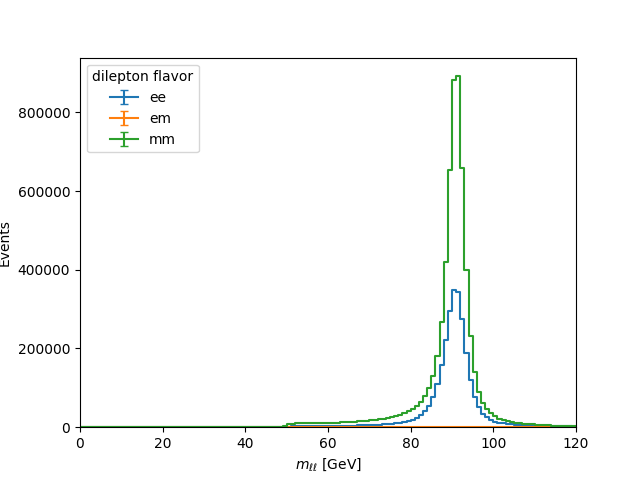

(<Figure size 640x480 with 1 Axes>,
 {'ee': [(<ErrorbarContainer object of 3 artists>,
    <ErrorbarContainer object of 3 artists>)],
  'em': [(<ErrorbarContainer object of 3 artists>,
    <ErrorbarContainer object of 3 artists>)],
  'mm': [(<ErrorbarContainer object of 3 artists>,
    <ErrorbarContainer object of 3 artists>)],
  'legend': <matplotlib.legend.Legend at 0x7f46db9055c0>})

In [13]:
plot.plot1d(hists['zMass'].value.sum('dataset'), overlay='channel',  error_opts={})

<IPython.core.display.Javascript object>


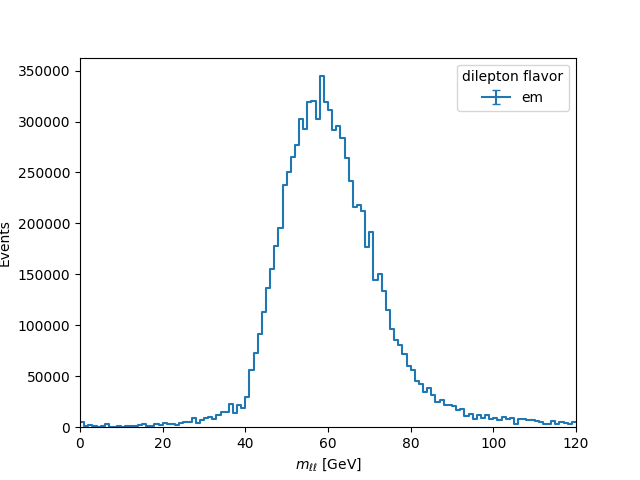

(<Figure size 640x480 with 1 Axes>,
 {'em': [(<ErrorbarContainer object of 3 artists>,
    <ErrorbarContainer object of 3 artists>)],
  'legend': <matplotlib.legend.Legend at 0x7f46d9057dd8>})

In [15]:
plot.plot1d(hists['zMass'].value.sum('dataset')['em'], overlay='channel', error_opts={})